# RNN training attempt 02

We will start with the feedforward encoding scheme, but modify it heavily so that we encode each hook in terms of (note, duration, chord) rather than in a timestep grid. So it will actually more closely resemble the original JSON encoding.

We're still starting with the .npy files from the feedforward encoding though since those already have lots of nice cleanup/sanitization applied (like removing all rests).

## Setup

In [165]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# We'll use the note/chord encodings from simple feedforward as a starting point
ff_path = 'gdrive/My Drive/Colab Notebooks/Thesis/simple-feedforward' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data

### Import from simple-feedforward

In [166]:
# Load encoded notes and chords
encoded_notes_path = os.path.join(ff_path, "encoded_notes.npy")
encoded_chords_path = os.path.join(ff_path, "encoded_chords.npy")
encoded_notes = np.load(encoded_notes_path)
encoded_chords = np.load(encoded_chords_path)

# Load song names
song_names_path = os.path.join(ff_path, "song_names.pkl")
opened_file = open(song_names_path, "rb")
song_names = pkl.load(opened_file)
opened_file.close()

num_hooks = len(song_names)
print(f"Loaded data. Number of 8-bar hooks: {num_hooks}")

Loaded data. Number of 8-bar hooks: 3448


## Preprocess

### Reshape into 3D tensors

In [167]:
NOTE_ONE_HOT_VECTOR_LENGTH = 38
CHORD_ONE_HOT_VECTOR_LENGTH = 32
NUM_16_NOTES_IN_8_BARS = 128

encoded_notes = encoded_notes.reshape((num_hooks, NOTE_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')
encoded_chords = encoded_chords.reshape((num_hooks, CHORD_ONE_HOT_VECTOR_LENGTH, NUM_16_NOTES_IN_8_BARS), order='F')

print(encoded_notes.shape)
print(encoded_chords.shape)

(3448, 38, 128)
(3448, 32, 128)


### Check how many hooks have no notes or chords on beat 1

In [168]:
def num_hooks_with_empty_first_beat():
    ret = 0

    for i in range(len(encoded_notes)):
        first_note_vect = encoded_notes[i, :, 0]
        first_chord_vect = encoded_chords[i, :, 0]
        if np.argmax(first_note_vect) == 0 and np.argmax(first_chord_vect) == 0:
            ret += 1
            print(f"Song: {song_names[i]}")
    
    print(f"\nNumber of hooks with no note or chord on first beat: {ret}")
    
num_hooks_with_empty_first_beat()

Song: Casanova
Song: Apple Pie
Song: Silly Love Songs
Song: Delirious
Song: Promised You A Miracle
Song: Whiskey Lullaby
Song: Good Stuff
Song: Every Breath You Take
Song: Every Breath You Take
Song: Every Breath You Take
Song: 1901
Song: It's Too Late
Song: Amber Island
Song: Jangan Play
Song: Everything Is Awesome
Song: Dancing Lasha Tumbai
Song: Wildest Dreams
Song: Loca ft Dizzee Rascal
Song: I'm A Believer
Song: Joanne
Song: How Will I Know
Song: It's the Things You Do
Song: Hungry Like The Wolf
Song: Sweet Dream
Song: He Won't Go
Song: Getting Better
Song: Night Fever
Song: The Good Ones
Song: Yerbatero
Song: Come See About Me
Song: Fall 4 U
Song: I Feel it Coming ft Daft Punk
Song: Adore You
Song: The Power Of Goodbye
Song: Standard Pop Song(Part1)
Song: Standard Pop Song(Part1)
Song: Standard Pop Song(Part1)
Song: Standard Pop Song(Part1)
Song: Speak Out Now
Song: Here Comes The Rain Again
Song: Bills Bills Bills
Song: It's gonna be me
Song: Live While We're Young
Song: You Bel

Not too many, but you might as well handle them since you'll need to handle chord/note independence anyways

### Read all hooks and find the distribution of time durations between "events".

An event is defined as either the beginning of a note, the beginning of a chord, or timestep 0 for the few cases where the hook begins with a rest. (Note that this means that timestep 0 is always an event.)

The number of time durations discovered will be the length of your rhythm one-hot vector.

In [169]:
# Helper function: add an item to a distribution map
def add_to_distribution_map(item, map):
    if item not in map:
        map[item] = 1
    else:
        map[item] += 1

# Helper function: print distribution map sorted by key
def print_distribution_map_keysort(map):
    sorted_map = sorted(map.items())
    for item in sorted_map:
        print(item)

# Helper function: print distribution map sorted by # occurences descending
def print_distribution_map_valsort(map):
    sorted_map = sorted(map.items(), key=lambda item: item[1], reverse=True)
    for item in sorted_map:
        print(item)

# Print and return duration of event distributions
def find_duration_distribution():
    map = {}

    # For every hook...
    for i in range(len(encoded_notes)):
        # Start at timestep 0
        t = 0

        # Scan for the next non-hold one-hot
        s = t + 1
        while s < NUM_16_NOTES_IN_8_BARS:
            note_vect = encoded_notes[i, :, s]
            chord_vect = encoded_chords[i, :, s]

            # If we have reached the next event, calcuate duration, add to map, and
            # update pointers
            if np.argmax(note_vect) != 0 or np.argmax(chord_vect) != 0:
                dur = s - t
                add_to_distribution_map(dur, map)
                t = s

            # Increment s every time
            s += 1
        
        # Add the final duration once we've reached the end of hook
        add_to_distribution_map(s - t, map)
    
    # Print results
    print(f"Number of possible durations: {len(map)}")
    print("\nSorted by duration:")
    print_distribution_map_keysort(map)
    print("\nSorted by # occurrences:")
    print_distribution_map_valsort(map)

    # Print total number of events
    num_events = sum(map.values())
    print(f"\nTotal number of events: {num_events}")

    # Return the map
    return map

duration_dist = find_duration_distribution()
            
            

Number of possible durations: 46

Sorted by duration:
(1, 26287)
(2, 74283)
(3, 7758)
(4, 23375)
(5, 849)
(6, 5771)
(7, 399)
(8, 4012)
(9, 211)
(10, 1568)
(11, 73)
(12, 847)
(13, 103)
(14, 546)
(15, 52)
(16, 1208)
(17, 10)
(18, 167)
(19, 5)
(20, 98)
(21, 9)
(22, 40)
(23, 2)
(24, 65)
(25, 1)
(26, 63)
(27, 2)
(28, 34)
(29, 1)
(30, 20)
(31, 3)
(32, 116)
(33, 1)
(34, 6)
(36, 3)
(42, 1)
(48, 4)
(50, 1)
(56, 1)
(57, 1)
(58, 1)
(64, 4)
(65, 1)
(68, 1)
(74, 1)
(128, 16)

Sorted by # occurrences:
(2, 74283)
(1, 26287)
(4, 23375)
(3, 7758)
(6, 5771)
(8, 4012)
(10, 1568)
(16, 1208)
(5, 849)
(12, 847)
(14, 546)
(7, 399)
(9, 211)
(18, 167)
(32, 116)
(13, 103)
(20, 98)
(11, 73)
(24, 65)
(26, 63)
(15, 52)
(22, 40)
(28, 34)
(30, 20)
(128, 16)
(17, 10)
(21, 9)
(34, 6)
(19, 5)
(48, 4)
(64, 4)
(31, 3)
(36, 3)
(23, 2)
(27, 2)
(65, 1)
(29, 1)
(57, 1)
(58, 1)
(42, 1)
(74, 1)
(25, 1)
(56, 1)
(33, 1)
(68, 1)
(50, 1)

Total number of events: 148020


Consider filtering out some of these, like only accept the top 16 durations or something.

### Only consider hooks that contain the top 16 durations

The top 16 durations all have > 100 occurrences (somewhat of an arbitrary choice of threshold)

In [170]:
NUM_ALLOWED_DURATIONS = 16

# Create a list of allowed durations
durations_sorted_by_freq = sorted(duration_dist.items(), key=lambda item: item[1], reverse=True)
durations_top_16 = durations_sorted_by_freq[0:NUM_ALLOWED_DURATIONS]
allowed_durations = []
for item in durations_top_16:
    allowed_durations.append(item[0])

print("Allowed durations (in descending order of frequency):")
print(allowed_durations)

# Scan all hooks and only keep hooks that have allowed event durations
encoded_notes_filt = []
encoded_chords_filt = []
song_names_filt = []

for i in range(len(encoded_notes)):
    t = 0
    s = t + 1
    keep_this_hook = True
    while s < NUM_16_NOTES_IN_8_BARS:
        note_vect = encoded_notes[i, :, s]
        chord_vect = encoded_chords[i, :, s]

        # If we have reached the next event, calculate the duration and break out
        # if a non-allowed duration has been detected
        if np.argmax(note_vect) != 0 or np.argmax(chord_vect) != 0:
            dur = s - t
            if dur not in allowed_durations:
                keep_this_hook = False
                break
            t = s
        
        # Increment s every time
        s += 1

    # Don't forget the last step
    last_dur = s - t
    if last_dur not in allowed_durations:
        keep_this_hook = False
    
    # Decide if the hook should be kept
    if keep_this_hook:
        encoded_notes_filt.append(encoded_notes[i])
        encoded_chords_filt.append(encoded_chords[i])
        song_names_filt.append(song_names[i])

encoded_notes_filt = np.array(encoded_notes_filt)
encoded_chords_filt = np.array(encoded_chords_filt)

# Print number of hooks removed
num_songs_removed = len(encoded_notes) - len(encoded_notes_filt)
print(f"\nNumber of hooks removed: {num_songs_removed}")

# Print shapes
print(encoded_notes_filt.shape)
print(encoded_chords_filt.shape)
print(len(song_names_filt))


Allowed durations (in descending order of frequency):
[2, 1, 4, 3, 6, 8, 10, 16, 5, 12, 14, 7, 9, 18, 32, 13]

Number of hooks removed: 364
(3084, 38, 128)
(3084, 32, 128)
3084


Update variables and double check that filtering worked as expected

In [171]:
encoded_notes = encoded_notes_filt
encoded_chords = encoded_chords_filt
song_names = song_names_filt

duration_dist = find_duration_distribution()

Number of possible durations: 16

Sorted by duration:
(1, 24454)
(2, 69766)
(3, 7184)
(4, 21595)
(5, 781)
(6, 5309)
(7, 360)
(8, 3672)
(9, 181)
(10, 1412)
(12, 751)
(13, 74)
(14, 491)
(16, 1090)
(18, 131)
(32, 87)

Sorted by # occurrences:
(2, 69766)
(1, 24454)
(4, 21595)
(3, 7184)
(6, 5309)
(8, 3672)
(10, 1412)
(16, 1090)
(5, 781)
(12, 751)
(14, 491)
(7, 360)
(9, 181)
(18, 131)
(32, 87)
(13, 74)

Total number of events: 137338


## Encode dataset in terms of (note, chord, duration)

### Encode each hook as a sequence of events, where each event has a note, chord and duration, each specified as one-hot. The one-hots are concatenated for each event.

If the event is a new note but the chord is a hold, the previous chord is repeated.

If the event is a new chord but the note is a hold, the note is still marked as "hold".

If the first timestep has no note, mark first event's note as hold.

If the first timestep has no chord, mark first event's chord as hold.



In [172]:
# Helper function: convert a duration into its one-hot vector representation
# (vector is represented as numpy array)
def duration_to_one_hot(dur):
    one_hot = np.zeros(len(allowed_durations), dtype=int)
    idx = allowed_durations.index(dur)
    one_hot[idx] = 1
    return one_hot

# Testing area
print(np.argmax(duration_to_one_hot(2)))  # should be 0
print(np.argmax(duration_to_one_hot(4)))  # should be 2
print(np.argmax(duration_to_one_hot(13))) # should be 15

0
2
15


In [173]:
encoded_dataset_ragged = []

def encode_ragged():
    # For every hook...
    for i in range(len(encoded_notes)):
        # Start at timestep 0
        t = 0
        events = []
        note_vect = encoded_notes[i, :, t]
        chord_vect = encoded_chords[i, :, t]

        # Scan for the next non-hold one-hot
        s = t + 1
        while s < NUM_16_NOTES_IN_8_BARS:
            note_vect_scan = encoded_notes[i, :, s]
            chord_vect_scan = encoded_chords[i, :, s]

            # If we have reached the next event, encode the current event
            if np.argmax(note_vect_scan) != 0 or np.argmax(chord_vect_scan) != 0:
                dur = s - t
                duration_vect = duration_to_one_hot(dur)

                # Concatenate vectors and add current event
                event_vect = np.concatenate([note_vect, chord_vect, duration_vect])
                events.append(event_vect)

                # Move t pointer such that the next event is now the current event
                t = s

                # Update the note vector every time
                # (this means some notes might be holds, if only the chord has changed)
                note_vect = encoded_notes[i, :, t]

                # Only update the chord vector if the new chord is NOT a hold
                if np.argmax(chord_vect_scan) != 0:
                    chord_vect = encoded_chords[i, :, t]
                

            # Increment s every time
            s += 1
        
        # Don't forget the final event!
        last_dur = s - t
        last_duration_vect = duration_to_one_hot(last_dur)
        last_event_vect = np.concatenate([note_vect, chord_vect, last_duration_vect])
        events.append(last_event_vect)

        # Finally, add the hook to your master dataset list
        encoded_dataset_ragged.append(events)

# Let it rip
encode_ragged()
print(f"Number of hooks processed: {len(encoded_dataset_ragged)}")

# Sanity check: check that the total number of events matches what you found before
total_num_events = 0
for hook in encoded_dataset_ragged:
    total_num_events += len(hook)
print(f"Total number of events: {total_num_events}")

# Print average number of events in each hook
print(f"Average number of events per hook: {total_num_events / len(encoded_dataset_ragged)}")



Number of hooks processed: 3084
Total number of events: 137338
Average number of events per hook: 44.53242542153048


## Set up Music21 dev environment

### Import and install necessary packages

In [174]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update > /dev/null

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null
#!apt-get install lilypond

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
#!apt-get install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...

installing lilypond...
installing fluidsynth...
done!
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth 1.1.9
GNU LilyPond 2.18.2

Copyright (c) 1996--2012 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.



These functions will make it easy to show and play back Music21 streams

In [175]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Note translation

In [176]:
C3_MIDI_VAL = 48

# Given a single event (represented as 1D numpy vector), return the note, chord
# and duration vectors that comprise it
def parse_event_vect(event):
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = a + CHORD_ONE_HOT_VECTOR_LENGTH
    c = b + NUM_ALLOWED_DURATIONS
    note_vect = event[0:a]
    chord_vect = event[a:b]
    duration_vect = event[b:c]
    return note_vect, chord_vect, duration_vect

# Given a one-hot encoding of a note, return the MIDI value of that note, or 0
# if the note encodes a hold
def decode_note_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0
    else:
        return idx + C3_MIDI_VAL - 1

# Given a one-hot encoding of a duration, return the integer value of the duration
# in number of 16-note timesteps
def decode_duration_one_hot(one_hot):
    idx = np.argmax(one_hot)
    return allowed_durations[idx]

# Main note translation logic: given a list of encoded hook events, generate a
# Music21 notes stream
def translate_notes(events):
    # Initialize music21 stream
    s = music21.stream.Part()

    # Move event step i to the first note in the melody, keeping track of
    # durations as you go
    i = 0
    dur = 0
    while i < len(events):
        note_vect, chord_vect, duration_vect = parse_event_vect(events[i])
        note_val = decode_note_one_hot(note_vect)
        if note_val != 0:
            break
        else:
            dur += decode_duration_one_hot(duration_vect)
            i += 1
    
    # Create a rest of the appropriate length if needed
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(dur / 4)
        s.append(rest)
    
    # Now add all the notes. event i is always the start of a new note
    dur = 0
    while i < len(events):
        note_vect, chord_vect, duration_vect = parse_event_vect(events[i])
        note_val = decode_note_one_hot(note_vect)
        dur += decode_duration_one_hot(duration_vect)

        # Scan for the next note (or to the end of the hook) to determine
        # the note's duration
        j = i + 1
        while j < len(events):
            note_vect_lookahead, chord_vect_lookahead, duration_vect_lookahead = parse_event_vect(events[j])
            note_val_lookahead = decode_note_one_hot(note_vect_lookahead)
            if note_val_lookahead != 0:
                break
            else:
                dur += decode_duration_one_hot(duration_vect_lookahead)
                j += 1
        
        # Create the note and add to stream
        note = music21.note.Note(note_val)
        note.duration = music21.duration.Duration(dur / 4)
        s.append(note)
        dur = 0

        # Move event step to next note (or end of hook)
        i = j

    # Return the stream
    return s


### Chord translation

In [177]:
# First re-create the mapping between chords and one-hot indices

allowed_chords = [
    '00-dim',
    '00-maj',
    '00-min',
    '01-dim',
    '01-maj',
    '02-dim',
    '02-maj',
    '02-min',
    '03-dim',
    '03-maj',
    '03-min',
    '04-dim',
    '04-maj',
    '04-min',
    '05-maj',
    '05-min',
    '06-dim',
    '06-maj',
    '07-dim',
    '07-maj',
    '07-min',
    '08-dim',
    '08-maj',
    '09-dim',
    '09-maj',
    '09-min',
    '10-maj',
    '10-min',
    '11-dim',
    '11-maj',
    '11-min'
]

def create_converted_chord_to_idx_map():
    map = []
    start_idx = 1 # start at 1 since idx 0 is reserved for holds
    for chord_str in allowed_chords:
        map.append([chord_str, start_idx])
        start_idx += 1
    return map

converted_chord_to_idx_map = create_converted_chord_to_idx_map()
for item in converted_chord_to_idx_map:
    print(item)

['00-dim', 1]
['00-maj', 2]
['00-min', 3]
['01-dim', 4]
['01-maj', 5]
['02-dim', 6]
['02-maj', 7]
['02-min', 8]
['03-dim', 9]
['03-maj', 10]
['03-min', 11]
['04-dim', 12]
['04-maj', 13]
['04-min', 14]
['05-maj', 15]
['05-min', 16]
['06-dim', 17]
['06-maj', 18]
['07-dim', 19]
['07-maj', 20]
['07-min', 21]
['08-dim', 22]
['08-maj', 23]
['09-dim', 24]
['09-maj', 25]
['09-min', 26]
['10-maj', 27]
['10-min', 28]
['11-dim', 29]
['11-maj', 30]
['11-min', 31]


In [178]:
C2_MIDI_VAL = 36

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = ''
    map_lookup_successful = False
    for item in converted_chord_to_idx_map:
        if item[1] == idx:
            str_form = item[0]
            map_lookup_successful = True
            break

    if not map_lookup_successful:
        raise Exception("Error when converting one-hot idx to str_form!")
    else:
        return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    if chord_class == 'dim':
        mid -= 1
    hi = low + 16
    if chord_class == 'dim' or chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]

# Main chord translation logic: given a list of encoded hook events, generate a
# Music21 chords stream
def translate_chords(events):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # Move event step i to the first chord in the melody, keeping track of
    # durations as you go
    i = 0
    dur = 0
    while i < len(events):
        note_vect, chord_vect, duration_vect = parse_event_vect(events[i])
        chord_item = decode_chord_one_hot(chord_vect)
        if chord_item != 0:
            break
        else:
            dur += decode_duration_one_hot(duration_vect)
            i += 1

    # Create a rest of the appropriate length if needed
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(dur / 4)
        s.append(rest)

    # Now add all the chords. Remove all repeats and holds.
    # event i is always the start of a different chord
    dur = 0
    while i < len(events):
        note_vect, chord_vect, duration_vect = parse_event_vect(events[i])
        chord_item = decode_chord_one_hot(chord_vect)
        dur += decode_duration_one_hot(duration_vect)

        # Scan for the next non-repeat chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < len(events):
            note_vect_lookahead, chord_vect_lookahead, duration_vect_lookahead = parse_event_vect(events[j])
            chord_item_lookahead = decode_chord_one_hot(chord_vect_lookahead)
            if chord_item_lookahead != chord_item and chord_item_lookahead != 0:
                break
            else:
                dur += decode_duration_one_hot(duration_vect_lookahead)
                j += 1
        
        # Create the note and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration(dur / 4)
        s.append(chord)
        dur = 0

        # Move event step to next chord (or end of hook)
        i = j
    
    # Return the stream
    return s
    

### Combine notes and chords into a score and .wav file

In [179]:
# Given a notes stream and chords stream, create a 2-part stream
def combine_streams(notes_stream, chords_stream):
    master_score = music21.stream.Score()
    master_score.append(notes_stream)
    master_score.append(chords_stream)
    master_score[1].offset = 0.0
    return master_score

# Given a list of events defining a hook, display and play the resulting score
def translate_events(events):
    melody = translate_notes(events)
    chords = translate_chords(events)
    score = combine_streams(melody, chords)
    show(score)
    play(score)

### Test out your functions on an example from the dataset as a sanity check

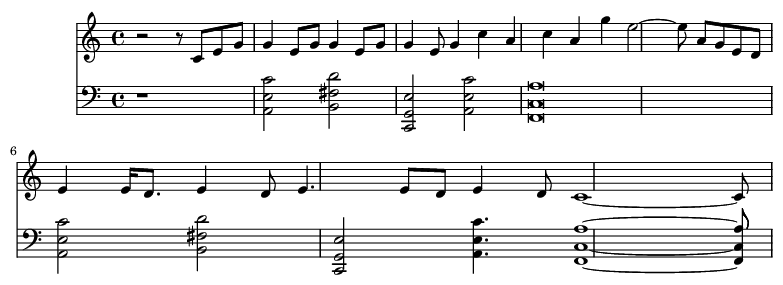

In [180]:
def test_translation(name):
    hook_found = False
    for i in range(len(song_names)):
        if song_names[i] == name:
            hook_found = True
            events = encoded_dataset_ragged[i]
            translate_events(events)
    if not hook_found:
        print("No hooks with that name were found")

test_translation("Fall 4 U")

## Create input and target sequences to be fed into your RNN model

### First, find the minimum, maximum and average number of events in a hook for your dataset

In [181]:
def find_min_event_count():
    min_count = float("inf")
    name = ""
    for i in range(len(encoded_dataset_ragged)):
        hook = encoded_dataset_ragged[i]
        if len(hook) < min_count:
            min_count = len(hook)
            name = song_names[i]

    print(f"Min number of events in a hook: {min_count}")
    print(f"Song name with min: {name}\n")

def find_max_event_count():
    max_count = float("-inf")
    name = ""
    for i in range(len(encoded_dataset_ragged)):
        hook = encoded_dataset_ragged[i]
        if len(hook) > max_count:
            max_count = len(hook)
            name = song_names[i]

    print(f"Max number of events in a hook: {max_count}")
    print(f"Song name with min: {name}\n")

def find_avg_event_count():
    total_num_events = 0
    for hook in encoded_dataset_ragged:
        total_num_events += len(hook)
    
    avg = total_num_events / len(encoded_dataset_ragged)
    print(f"Avg number of events in a hook: {avg}")

find_min_event_count()
find_max_event_count()
find_avg_event_count()




Min number of events in a hook: 6
Song name with min: Silly Love Songs

Max number of events in a hook: 128
Song name with min: Bitch Better Have My Money

Avg number of events in a hook: 44.53242542153048


### Split dataset into input sequences and output vectors

In [182]:
for i in range(1):
    print(i)

0


In [183]:
SEQ_LENGTH = 4 # kind of an arbitrary choice

# Each input is a sequence of SEQ_LENGTH events. Output is the next event after the input sequence
inputs = []
outputs = []
song_names_long = []
num_hooks_skipped = 0

# Populate input and output lists
for i in range(len(encoded_dataset_ragged)):
    hook = encoded_dataset_ragged[i]
    
    # If the hook doesn't have enough events, skip it
    if SEQ_LENGTH > len(hook) - 1:
        num_hooks_skipped += 1

    # Otherwise, scan the hook
    else:
        for j in range(len(hook) - SEQ_LENGTH):
            inputs.append(hook[j:j + SEQ_LENGTH])
            outputs.append(hook[j + SEQ_LENGTH])
            song_names_long.append(song_names[i])

# Convert to numpy
inputs = np.array(inputs)
outputs = np.array(outputs)
print(f"Inputs shape: {inputs.shape}")
print(f"Outputs shape: {outputs.shape}")
print(f"Number of hooks w/o enough events that were skipped: {num_hooks_skipped}")


Inputs shape: (125002, 4, 86)
Outputs shape: (125002, 86)
Number of hooks w/o enough events that were skipped: 0


## Create and compile RNN model

In [184]:
input_length = inputs.shape[2]
output_length = input_length

model = keras.Sequential([
    layers.Input(shape=(SEQ_LENGTH, input_length)),
    #layers.Bidirectional(layers.LSTM(512)),
    #layers.Bidirectional(layers.GRU(512)),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    #layers.GRU(512),
    #layers.GRU(512, return_sequences=True),
    #layers.Dropout(0.3),
    #layers.GRU(256),
    layers.Dense(output_length, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 32)             15232     
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dense_7 (Dense)             (None, 86)                2838      
                                                                 
Total params: 26,390
Trainable params: 26,390
Non-trainable params: 0
_________________________________________________________________


## Write generation logic and test out untrained model

Input sequence from Hey Soul Sister:


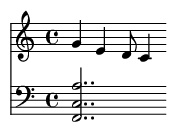

Generated output:


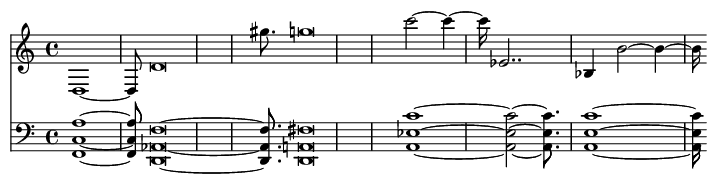

In [185]:
# Given an input idx, return an input sequence
# that is nicely reshaped for feeding into the model
def get_input(idx):
    input = inputs[idx].reshape(1, SEQ_LENGTH, input_length)
    return input

# Given an input sequence of events, predict the next event.
# Softmax temperature determines how random the sampling is
# (close to 0 is "harder" distribution, 1 is default softmax, and
# >1 is "softer" i.e. closer to uniform sampling).
def predict_next_event(input, temperature):
    output = model(input)
    output = np.array(output[0, :]) # turn into 1D numpy vector

    # Extract note, chord and duration vectors and softmax them
    note_vect, chord_vect, duration_vect = parse_event_vect(output)
    note_vect = softmax(note_vect / temperature)
    chord_vect = softmax(chord_vect / temperature)
    duration_vect = softmax(duration_vect / temperature)

    # Sample from softmax vectors
    note_sample = np.random.multinomial(1, note_vect)
    chord_sample = np.random.multinomial(1, chord_vect)
    duration_sample = np.random.multinomial(1, duration_vect)
    a = NOTE_ONE_HOT_VECTOR_LENGTH
    b = a + CHORD_ONE_HOT_VECTOR_LENGTH
    pred_note_idx = np.argmax(note_sample)
    pred_chord_idx = np.argmax(chord_sample) + a
    pred_duration_idx = np.argmax(duration_sample) + b

    # Return your predicted event as a flattened 1D numpy array
    prediction = np.zeros(output_length, dtype=int)
    prediction[pred_note_idx] = 1
    prediction[pred_chord_idx] = 1
    prediction[pred_duration_idx] = 1
    return prediction

# Given an input idx and softmax temperature (see above for explanation),
# generate 8 bars worth of events. Note that it's very easy to change
# the amount of output later if you want
def generate_hook(idx, temperature):
    # Setup
    hook = []
    total_dur = 0
    input = get_input(idx)

    # Keep making predictions until you fill up 128 timesteps (duration overshoots
    # allowed, though no new events allowed after step 127)
    while total_dur < NUM_16_NOTES_IN_8_BARS:
        # Make prediction and add to hook event list
        prediction = predict_next_event(input, temperature)
        note_vect, chord_vect, duration_vect = parse_event_vect(prediction)
        dur = decode_duration_one_hot(duration_vect)
        hook.append(prediction)
        total_dur += dur

        # "Shift" the input sequence by one event
        prediction = prediction.reshape(1, 1, -1)
        input = np.concatenate((input[:, 1:, :], prediction), axis=1)

    # Show and play back the generated hook
    translate_events(hook)

# Use a random input idx to generate a hook with a given softmax temp
def generate_random_hook(temperature):
    idx = np.random.randint(0, len(inputs))
    name = song_names_long[idx]
    print(f"Input sequence from {name}:")
    translate_events(inputs[idx])
    print("Generated output:")
    generate_hook(idx, temperature)

# Given a song name, generate a new hook using the first 4 events of that song's hook
# as input
def generate_hook_from_name(name, temperature):
    idx = 0
    hook_found = False
    for i in range(len(song_names_long)):
        if song_names_long[i] == name:
            idx = i
            hook_found = True
            break
    if not hook_found:
        print("No hook with that name was found!")
    else:
        print(f"Input sequence from {name}:")
        translate_events(inputs[idx])
        print("Generated output:")
        generate_hook(idx, temperature)
        
# Sanity check
generate_hook_from_name("Hey Soul Sister", 1.0)



## Train model

In [186]:
#model.fit(inputs, outputs, epochs=20) # comment out if loading pre-trained

## Save model

In [187]:
#model.save('saved_model.h5') # comment this out if loading pre-trained

## Load model (change the file path to whatever .h5 file you want to load)

In [188]:
# change this path if needed
saved_model_path = 'gdrive/My Drive/Colab Notebooks/Thesis/rnn-attempt-02/rnn02_publication.h5'

# load model
model = keras.models.load_model(saved_model_path)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 4, 32)             15232     
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 86)                2838      
                                                                 
Total params: 26,390
Trainable params: 26,390
Non-trainable params: 0
_________________________________________________________________


## Save schematic of model

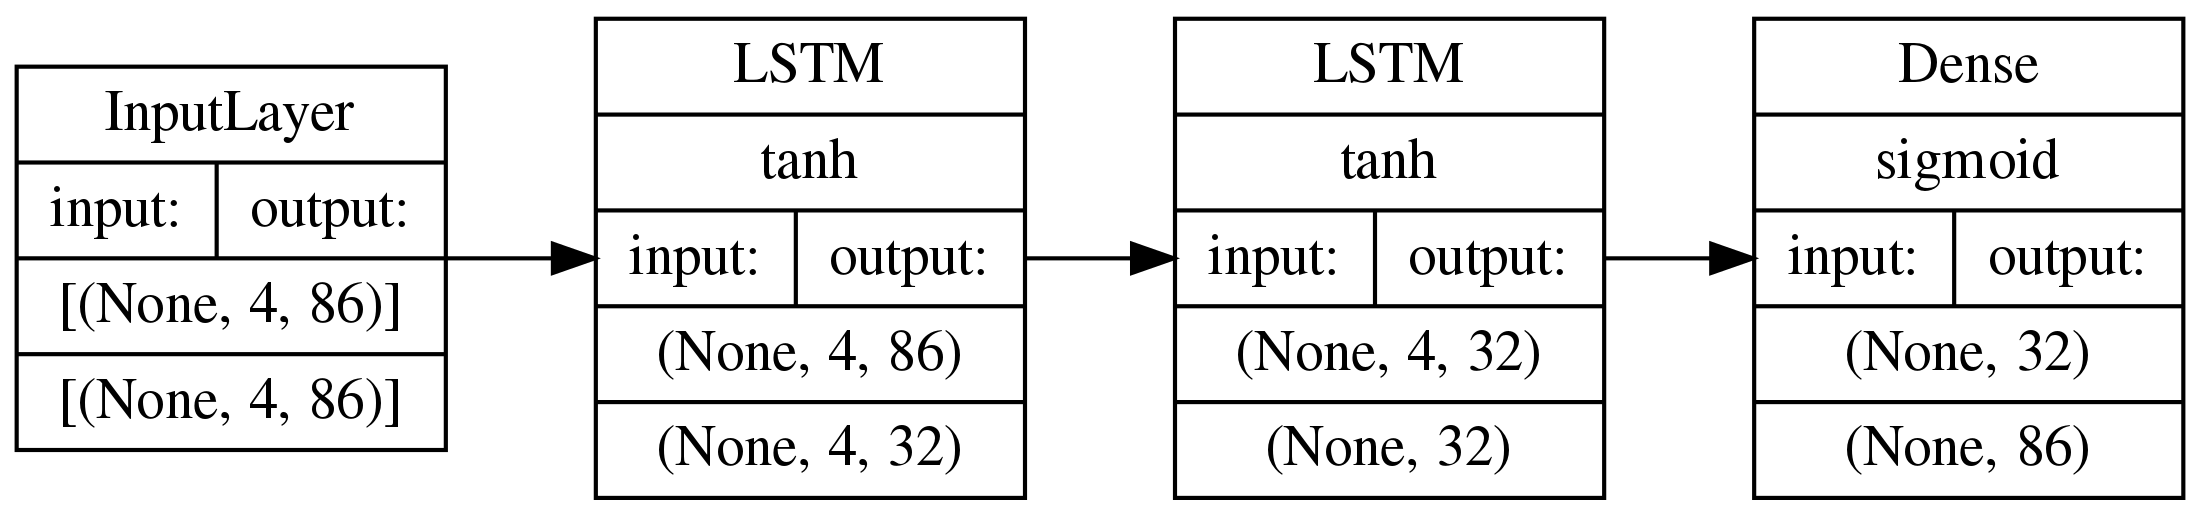

In [196]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, rankdir="LR", dpi=300, show_layer_activations=True)

## Generate some music!

Input sequence from Over My Head - Cable Car:


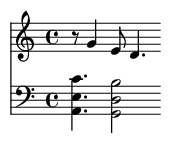

Generated output:


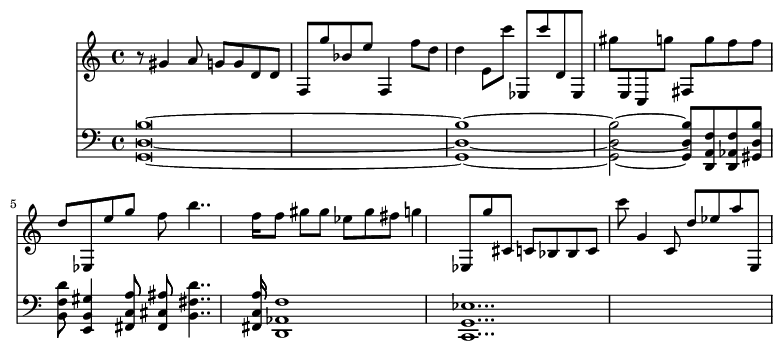

Input sequence from Hey Soul Sister:


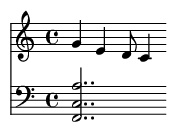

Generated output:


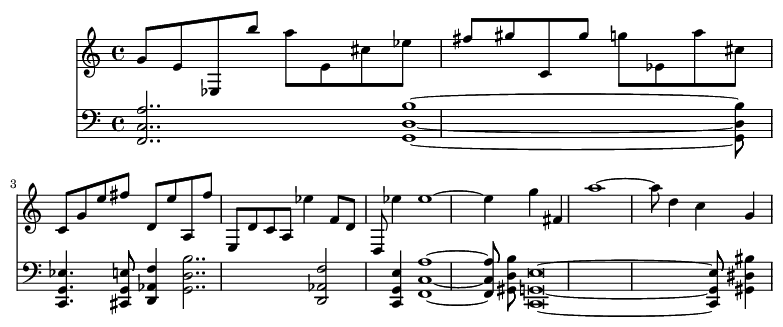

In [199]:
temp = 0.10
generate_random_hook(temp)
generate_hook_from_name("Hey Soul Sister", temp)